## Import used packages

In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import spatial
from math import sin, cos, sqrt, atan2, radians
import folium
from tqdm import tqdm

## Import data

In [2]:
bremen_trips = pd.read_csv("../data/processed/trips_weather.csv", index_col=0)
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])

In [3]:
bremen_trips.head(2)

,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,...,humidity_2m,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min
bike,,,,,,,,,,,,,,,,,,,,,
20685,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,0.0,0.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0
20626,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,16260.0,8.884911,53.078923,8.884911,53.078923,2985.0,2985.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0


In [4]:
bremen_trips.keys()

Index(['identification', 'start_time', 'end_time', 'duration_sec', 'start_lng',
       'start_lat', 'end_lng', 'end_lat', 'start_place', 'end_place',
       'start_plz', 'end_plz', 'temp_2m', 'humidity_2m', 'dew_point_2m',
       'max_at_2m', 'mean_speed_h/s', 'direction_degree_x', 'max_m/s',
       'min_mean_m/s', 'max_mean_m/s', 'direction_degree_y', 'min'],
      dtype='object')

## Functions that calculates distance moved towards the university of Bremen and main station

In [5]:
# Function that calculates if start or end location is closer to University of Bremen. 
# Returns the difference of the distances of the start and end location in kilometers.
# If value positive, end locations is closer to university. That means moved towards university.
def distanceToUni(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    uLat = radians(53.1069302) # University of Bremen Latitude
    uLng = radians(8.8499603)  # University of Bremen Longitude

    sdlon = uLng - sLng
    sdlat = uLat - sLat

    edlon = uLng - eLng
    edlat = uLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(uLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(uLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

def distanceToMainStation(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    msLat = radians(53.083122) # # Main station Latitude
    msLng = radians(8.813717) # # Main station Latitude

    sdlon = msLng - sLng
    sdlat = msLat - sLat

    edlon = msLng - eLng
    edlat = msLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(msLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(msLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

## Example of trip moving away from the university

- Red marker = University of Bremen
- Blue marker = Start location
- Green marker = End location

In [6]:
bremen_trips.head(2)

,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,...,humidity_2m,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min
bike,,,,,,,,,,,,,,,,,,,,,
20685,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,0.0,0.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0
20626,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,16260.0,8.884911,53.078923,8.884911,53.078923,2985.0,2985.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0


In [7]:
m = folium.Map(location=[53.1069302,8.8499603], zoom_start=13)

folium.Marker([53.1069302,8.8499603], popup='<i>Uni</i>',icon=folium.Icon(color='red')).add_to(m)
folium.Marker([53.083122,8.813717], popup='<i>Main Station</i>',icon=folium.Icon(color='red')).add_to(m)

row = 35
folium.Marker([bremen_trips.iloc[row,5],bremen_trips.iloc[row,4]], popup='<i>Start</i>').add_to(m)
folium.Marker([bremen_trips.iloc[row,7],bremen_trips.iloc[row,6]], popup='<i>End</i>',icon=folium.Icon(color='green')).add_to(m)

print('Moved km in direction to uni: ', distanceToUni(bremen_trips.iloc[row,4],bremen_trips.iloc[row,5],bremen_trips.iloc[row,6],bremen_trips.iloc[row,7]))
print('Moved km in direction to main station: ', distanceToMainStation(bremen_trips.iloc[row,4],bremen_trips.iloc[row,5],bremen_trips.iloc[row,6],bremen_trips.iloc[row,7]))

m

Moved km in direction to uni:  1.2799729582841826
Moved km in direction to main station:  -1.7491537704235693


## Add target variables and features to trips data

In [8]:
# Target variables lists
to_uni = []
to_main_station = []
to_uni_bool = []
to_main_station_bool = []

# Features lists
month = []
week_day = []
is_weekend = []
hour = []

for index, row in tqdm(bremen_trips.iterrows()):
    
    dist_to_uni = distanceToUni(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    dist_to_main_station = distanceToMainStation(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    
    day = row['start_time'].weekday()
    
    # Save datetime information
    month.append(row['start_time'].month)
    week_day.append(day)
    hour.append(row['start_time'].hour)
    
    if (day == 5) | (day == 6):
        is_weekend.append(1)
    else:
        is_weekend.append(0)
    
    # Save distances to corresponding list
    to_uni.append(dist_to_uni)
    to_main_station.append(dist_to_main_station)
    
    if dist_to_uni < 0:
        to_uni_bool.append(0)
    else:
        to_uni_bool.append(1)
        
    if dist_to_main_station < 0:
        to_main_station_bool.append(0)
    else:
        to_main_station_bool.append(1)
        
# Add columns to df
bremen_trips['to_uni'] = to_uni
bremen_trips['to_main_station'] = to_main_station
bremen_trips['to_uni_bool'] = to_uni_bool
bremen_trips['to_main_station_bool'] = to_main_station_bool
bremen_trips['month'] = month
bremen_trips['week_day'] = week_day
bremen_trips['is_weekend'] = is_weekend
bremen_trips['hour'] = hour

135443it [00:25, 5395.14it/s]


In [9]:
bremen_trips.sample(3)

,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,...,direction_degree_y,min,to_uni,to_main_station,to_uni_bool,to_main_station_bool,month,week_day,is_weekend,hour
bike,,,,,,,,,,,,,,,,,,,,,
20796,20648333,2019-08-18 13:42:00,2019-08-18 13:50:00,480.0,8.806869,53.074764,8.825922,53.076151,0.0,0.0,...,190.0,0.0,0.810542,-0.089174,1,0,8,6,1,13
20836,16605469,2019-06-01 18:06:00,2019-06-01 18:11:00,300.0,8.826071,53.078996,8.828417,53.082716,0.0,0.0,...,20.0,0.0,0.439290,-0.038718,1,0,6,5,1,18
20893,21556045,2019-09-05 11:19:00,2019-09-05 11:27:00,480.0,8.795669,53.084618,8.809404,53.080280,0.0,0.0,...,270.0,4.0,0.378499,0.789449,1,1,9,3,0,11


### Drop all information that are not available before a trips ends

In [10]:
bremen_trips.drop(columns={'identification','end_time','end_lng','end_lat','end_place','end_plz','duration_sec'}, inplace=True)

## Precheck on correlations to_uni_bool

In [11]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_uni_bool'])

start_lng            -0.133995
start_lat            -0.194858
start_place           0.046675
start_plz            -0.043057
temp_2m              -0.000556
humidity_2m          -0.011194
dew_point_2m         -0.009436
max_at_2m            -0.000321
mean_speed_h/s        0.007506
direction_degree_x    0.000670
max_m/s               0.007735
min_mean_m/s          0.004595
max_mean_m/s          0.007756
direction_degree_y    0.000359
min                   0.008262
month                -0.018003
week_day             -0.003862
is_weekend           -0.004743
hour                  0.007713
dtype: float64

- only start_lng and start_lat show significant correlations, anyway we check try to take more features into account

### Pearson correlation only for attributes with correlation higher than 0.005

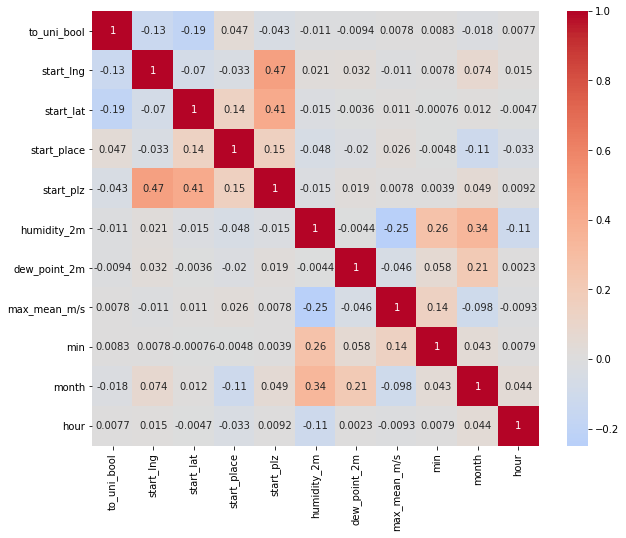

In [39]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni_bool','start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

# Predicting to_uni_bool - Classification

### Random Forest

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Feature selection
### Train on all features with correlation > 0.005

In [14]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [15]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Check on feature importance

In [16]:
names = ['start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

[(0.1836, 'start_lng'), (0.172, 'start_lat'), (0.1489, 'humidity_2m'), (0.1404, 'dew_point_2m'), (0.1338, 'max_mean_m/s'), (0.0964, 'hour'), (0.0611, 'month'), (0.0298, 'start_plz'), (0.0173, 'min'), (0.0166, 'start_place')]


### Only train on features with importance > 0.1

In [17]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [18]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Evaluation

In [19]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))

Training accuracy: 0.9978773280174243


- looks like overfitting --> perform grid search to optimize hyperparameters

### Performing grid search to optimize hyperparameters

In [20]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='accuracy', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [21]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.62496126 0.63228307 0.63603645 0.63172942 0.63262152 0.63382135
 0.6339444  0.59533633 0.64348091 0.6422816  0.64280469 0.64178927
 0.64200455 0.64092791 0.63077572 0.6478497  0.64824964 0.64508119
 0.64892654 0.64892659 0.64738844 0.64055874 0.64486574 0.65489464
 0.65375656 0.65431025 0.65514083 0.65464864 0.6418818  0.65357165
 0.65827859 0.65892462 0.65892459 0.65920148 0.6588631 ]
256 7 42


### Train model with optimized hyperparameters

In [22]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [23]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6709489266662975
Valiation accuracy: 0.6619085707254045


- looks like the model generalizes well with optimized hyperparameters

### Visualize predicted classes 0: trip not in direction to uni, 1: trip in direction to uni

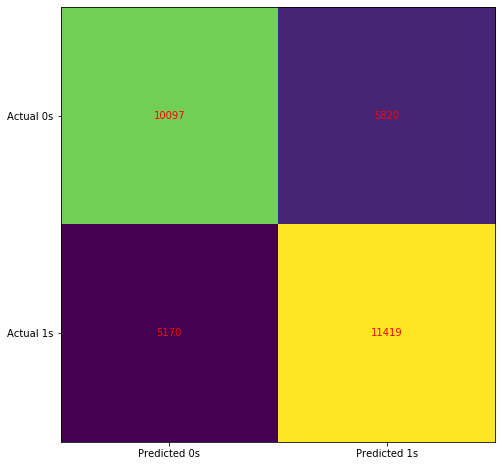

In [24]:
# Function that plots a confusion matrix given independent and target variable
def confusionMatrix(y, X):
    cm = confusion_matrix(y_val, rf.predict(X_val))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

confusionMatrix(y_val, rf.predict(X_val))

### Classification report

In [25]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.66      0.63      0.65     15917
           1       0.66      0.69      0.68     16589

    accuracy                           0.66     32506
   macro avg       0.66      0.66      0.66     32506
weighted avg       0.66      0.66      0.66     32506



## Apply to test set

### Add validation set to train set to obtain more training data

In [26]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [27]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Training + validation set performance

In [30]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6679164311341325
Valiation accuracy: 0.6666153940810927


### Test set performance

### The moment of truth

In [29]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6597005742411813


In [31]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65     23714
           1       0.66      0.68      0.67     25046

    accuracy                           0.66     48760
   macro avg       0.66      0.66      0.66     48760
weighted avg       0.66      0.66      0.66     48760



- model could perform better in terms of the accuracy score, however it seems to generalize very well (train, validation and test accuracy are almost the same)
- to improve the overall accuracy we would need more features with a significant correlation

## Try Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [34]:
model = LogisticRegression(solver='liblinear',multi_class='ovr', random_state=42, class_weight='balanced').fit(X_train, y_train)

In [35]:
print('Training accuracy: ' + str(model.score(X_train, y_train)))
print('Valiation accuracy: ' + str(model.score(X_val, y_val)))

Training accuracy: 0.5598316628827731
Valiation accuracy: 0.5602965606349597


In [36]:
model.predict_proba(X_val)

array([[0.48700002, 0.51299998],
       [0.42771358, 0.57228642],
       [0.51416833, 0.48583167],
       ...,
       [0.44576731, 0.55423269],
       [0.49293265, 0.50706735],
       [0.52429314, 0.47570686]])

In [37]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.56      0.45      0.50     15917
           1       0.56      0.66      0.61     16589

    accuracy                           0.56     32506
   macro avg       0.56      0.56      0.55     32506
weighted avg       0.56      0.56      0.56     32506



### Logistic regression performs worst than random forest. Do not use it!

# Predicting to_main_station_bool - Classification

## Precheck on correlations to_main_station_bool

In [38]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_main_station_bool'])

start_lng             0.066013
start_lat            -0.008463
start_place           0.085158
start_plz             0.160676
temp_2m               0.008639
humidity_2m          -0.020490
dew_point_2m         -0.004226
max_at_2m             0.008491
mean_speed_h/s        0.020066
direction_degree_x    0.001829
max_m/s               0.022077
min_mean_m/s          0.014331
max_mean_m/s          0.021390
direction_degree_y    0.001943
min                   0.004326
month                -0.019085
week_day             -0.004949
is_weekend           -0.004339
hour                 -0.037145
dtype: float64

- only start_plz shows significant correlations, anyway we check try to take more features into account

### Pearson correlation only for attributes with correlation higher than 0.005

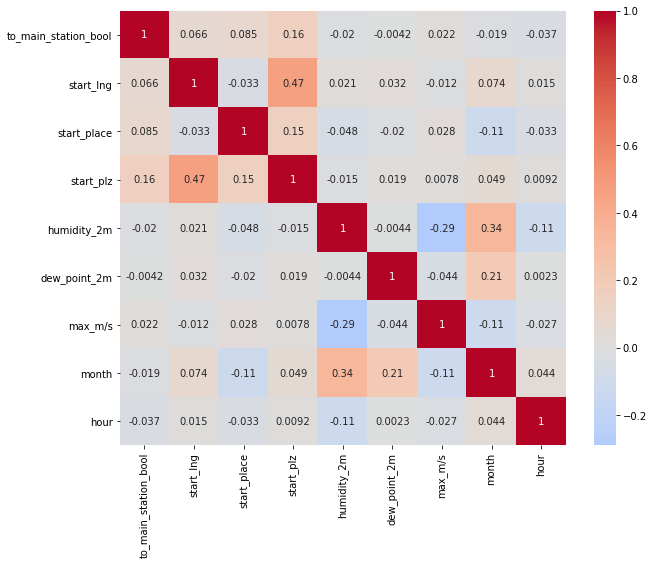

In [40]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_main_station_bool','start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

## Feature selection
### Train on all features with correlation > 0.005

In [41]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']]
y = bremen_trips['to_main_station_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [42]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Check on feature importance

In [44]:
names = ['start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

[(0.235, 'start_lng'), (0.1713, 'humidity_2m'), (0.1628, 'dew_point_2m'), (0.1358, 'max_m/s'), (0.104, 'hour'), (0.0932, 'start_plz'), (0.0667, 'month'), (0.0313, 'start_place')]


### Only train on features with importance > 0.1

In [45]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_plz','humidity_2m','dew_point_2m','max_m/s','hour']]
y = bremen_trips['to_main_station_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [46]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Evaluation

In [47]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))

Training accuracy: 0.9983387784484191


- looks like overfitting --> perform grid search to optimize hyperparameters

### Performing grid search to optimize hyperparameters

In [48]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.62462302 0.64471166 0.65394063 0.63978956 0.63782067 0.63815907
 0.63843594 0.62631523 0.64929528 0.6582476  0.64947994 0.65080261
 0.64831086 0.6482493  0.64508112 0.65550978 0.66166245 0.66378502
 0.66166243 0.6656309  0.66507712 0.64864947 0.66332358 0.66593853
 0.66609232 0.66744586 0.671076   0.66938399 0.66147777 0.67061456
 0.6753213  0.67516743 0.67578271 0.67630564 0.67599804]
256 7 42


### Train model with optimized hyperparameters

In [49]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [50]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6866382413201174
Valiation accuracy: 0.6777210361164093


- looks like the model generalizes well with optimized hyperparameters

### Visualize predicted classes 0: trip not in direction to main station, 1: trip in direction to main station

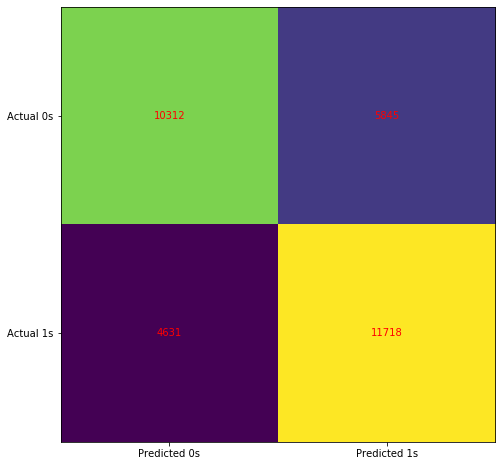

In [51]:
confusionMatrix(y_val, rf.predict(X_val))

### Classification report

In [52]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66     16157
           1       0.67      0.72      0.69     16349

    accuracy                           0.68     32506
   macro avg       0.68      0.68      0.68     32506
weighted avg       0.68      0.68      0.68     32506



## Apply to test set

### Add validation set to train set to obtain more training data

In [53]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [54]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Training + validation set performance

In [55]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6815638591188584
Valiation accuracy: 0.6791669230295946


### Test set performance

### The moment of truth

In [56]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6817063166529943


In [57]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67     24287
           1       0.68      0.70      0.69     24473

    accuracy                           0.68     48760
   macro avg       0.68      0.68      0.68     48760
weighted avg       0.68      0.68      0.68     48760



# Predicting to_uni - Regression

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Check on correlations to_uni

In [58]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_uni'])

start_lng            -0.195634
start_lat            -0.286293
start_place          -0.021402
start_plz            -0.080076
temp_2m              -0.000175
humidity_2m          -0.000371
dew_point_2m          0.000227
max_at_2m            -0.000135
mean_speed_h/s        0.000917
direction_degree_x    0.000092
max_m/s               0.001179
min_mean_m/s         -0.000954
max_mean_m/s          0.000749
direction_degree_y   -0.000164
min                   0.002682
month                -0.000816
week_day             -0.001846
is_weekend           -0.001993
hour                 -0.002399
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.05

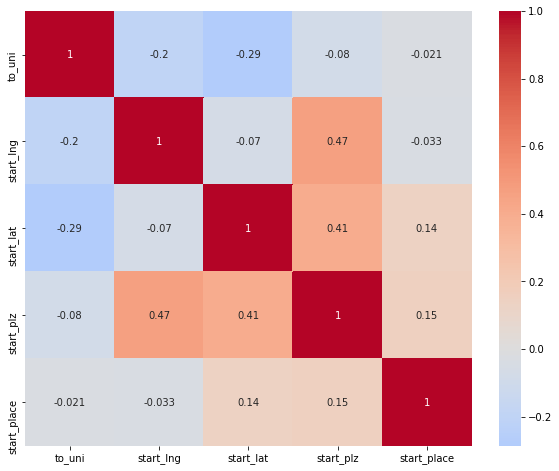

In [60]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni','start_lng','start_lat','start_plz','start_place']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

### Choose features with correlation > 0.05

In [66]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz']]
y = bremen_trips['to_uni']

### Polynomial regression

In [67]:
def chooseDegree(X, y):
    
    # Splitting data into train and validation set
    #X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
    #X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

    r2_train = []
    r2_val = []
    rmses_val = []
    degrees = np.arange(1, 8)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)
        X_val_poly = poly_features.fit_transform(X_val)
        
        # Evaluate
        r2_train.append(poly_reg.score(X_poly_train, y_train))
        r2_val.append(poly_reg.score(X_val_poly,y_val))

        # Compare with val data
        poly_predict = poly_reg.predict(X_val_poly)
        poly_mse = mean_squared_error(y_val, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses_val.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Suggested degree {} with RMSE of validation set {}'.format(min_deg, min_rmse))
    
    # Create model with optimal degree
    poly_features = PolynomialFeatures(degree=min_deg, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    X_val_poly = poly_features.fit_transform(X_val)

    # Evaluate
    print('R2 train score with suggested degree: ', poly_reg.score(X_poly_train, y_train))
    print('R2 validation score with suggested degree: ', poly_reg.score(X_val_poly,y_val))
    
    
    # Evaluation plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    #ax_rmses_val = fig.add_subplot(111)
    axes[0].plot(degrees, rmses_val, label='rmses_val')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('RMSE')
    
    #ax_r2_train = fig.add_subplot(111)
    axes[1].plot(degrees, r2_train, label='R2_train')
    axes[1].set_yscale('linear')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_train')
    axes[1].set_label('R2_train')
    #axes[1].set_ylim(0,1)
    
    #ax_r2_val = fig.add_subplot(111)
    axes[1].plot(degrees, r2_val, label='R2_val')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_val')
    
    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()

Suggested degree 3 with RMSE of validation set 1.2206224693810743
R2 train score with suggested degree:  0.2689015754290762
R2 validation score with suggested degree:  0.24787385015087826


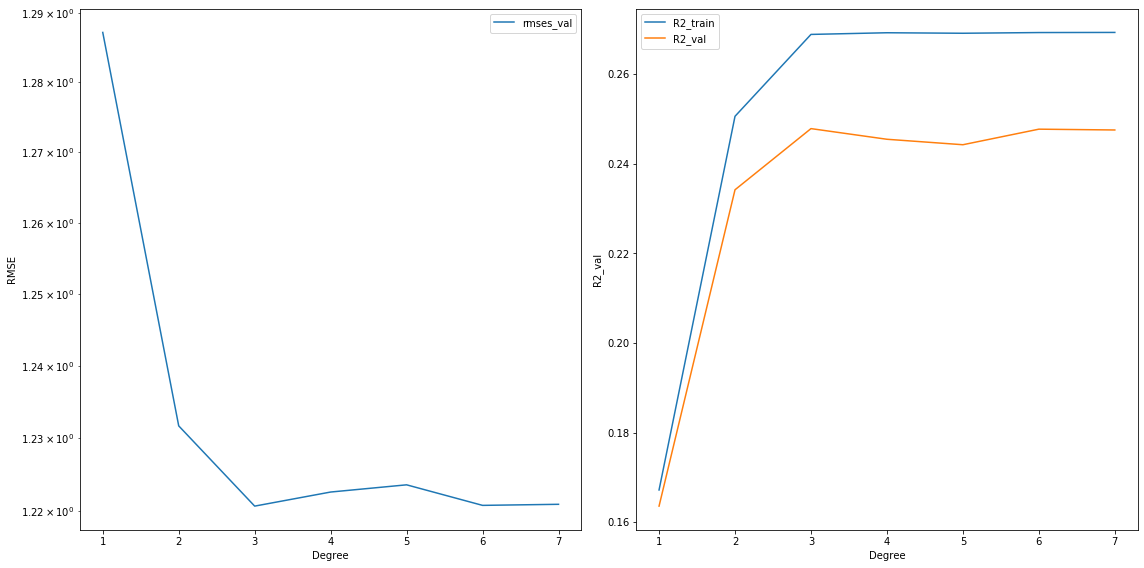

In [68]:
chooseDegree(X,y)

## Apply to test set

### Add validation set to train set to obtain more training data

In [69]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)

lin = LinearRegression()

### Training + validation set performance

In [70]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.26338889380546915

### Test set performance

In [71]:
X_test_poly = poly.fit_transform(X_test)
lin.score(X_test_poly,y_test)

0.2364139870112021

- no accurate predictions, features with higher significance required.

# Predicting to_main_station - Regression

## Check on correlations to_main_station

In [72]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_main_station'])

start_lng             0.098213
start_lat             0.029197
start_place           0.098993
start_plz             0.284381
temp_2m               0.012753
humidity_2m          -0.021786
dew_point_2m         -0.001042
max_at_2m             0.012657
mean_speed_h/s        0.015122
direction_degree_x    0.002625
max_m/s               0.017047
min_mean_m/s          0.010261
max_mean_m/s          0.016154
direction_degree_y    0.002530
min                   0.003294
month                -0.002027
week_day             -0.008870
is_weekend           -0.008817
hour                 -0.013742
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.05

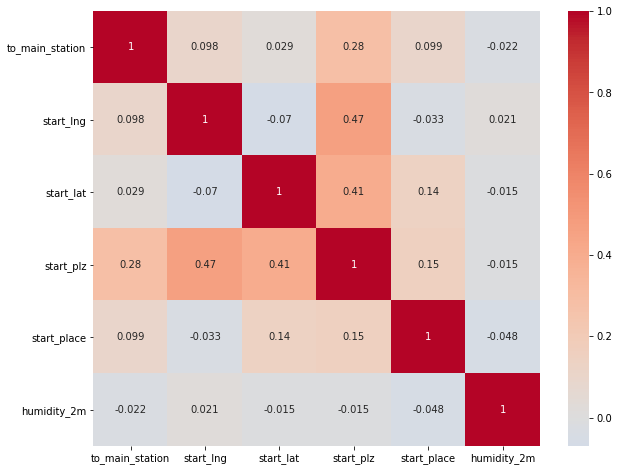

In [74]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_main_station','start_lng','start_lat','start_plz','start_place','humidity_2m']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

### Choose features with correlation > 0.05

In [76]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','start_place','humidity_2m']]
y = bremen_trips['to_main_station']

### Polynomial regression

Suggested degree 6 with RMSE of validation set 1.2143730457256494
R2 train score with suggested degree:  0.26345107143847857
R2 validation score with suggested degree:  0.25555570506710756


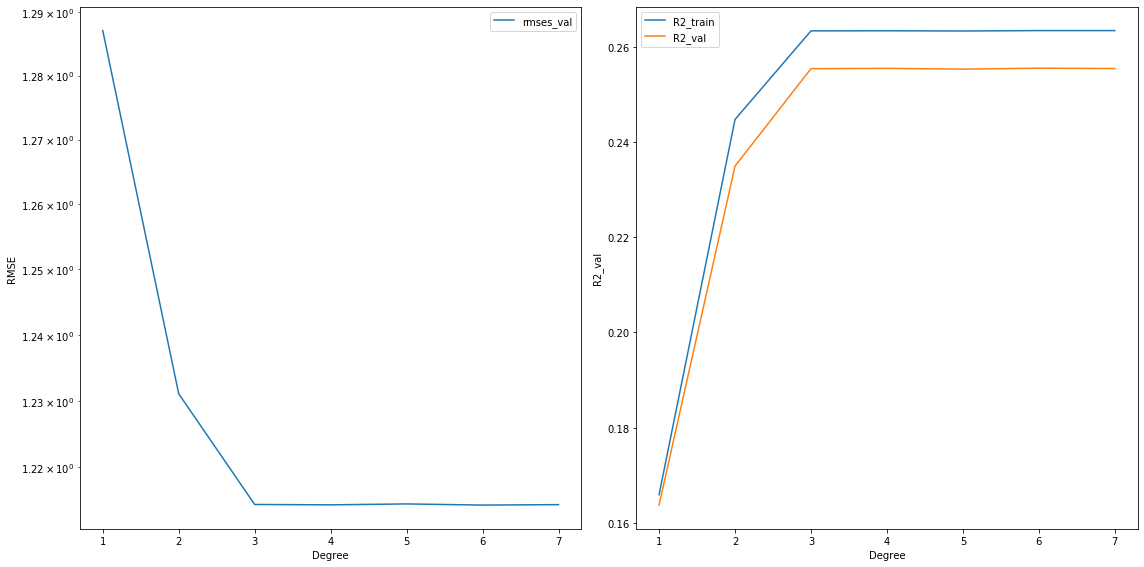

In [77]:
chooseDegree(X,y)

- choose degree 3

## Apply to test set

### Add validation set to train set to obtain more training data

In [78]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)

lin = LinearRegression()

### Training + validation set performance

In [83]:
lin.fit(X_train_poly, y_train)
print(lin.score(X_train_poly, y_train))

0.26138012306062963


### Test set performance

In [84]:
X_test_poly = poly.fit_transform(X_test)
lin.score(X_test_poly,y_test)

0.23748453801299008

- no accurate predictions, features with higher significance required.